# Autoencoder from scratch

# Demo autoencoder

## Objective

In this notebook, I implement a demo for the autoencoder building process. The goal is to:

- Implement a basic pipeline that can be later used in the complete version with scripts.
- Visualize the data and key steps (inputs, reconstructions, errors).
- Define the architecture in a basic, modular way to allow experimentation.
- Assess training performance and plot evaluation results.

This version works on a **single object class** from the MVTec AD dataset (e.g., `metal_nut`) using **grayscale images resized to 64×64**, and a simple **autoencoder** implemented from scratch in NumPy.

## 1. Preprocessing the Data
In this first section, I define a prototype for the preprocessing pipeline.
Its purpose is to:

- Load images from a selected class (e.g., 'metal_nut') in the MVTec AD dataset.
- Convert them to grayscale for simplicity.
- Resize them to a fixed shape (64×64) to standardize input dimensions.
- Normalize pixel values to the [0, 1] range for stability in training.

This prototype will later be converted into a reusable script module for the full pipeline.

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def load_images(folder_path, image_size=(64, 64), grayscale=True):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            path = os.path.join(folder_path, filename)
            img = cv2.imread(path)
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, image_size)
            img = img.astype(np.float32) / 255.0 
            images.append(img)

    images = np.array(images)
    
    if grayscale:
        images = images[..., np.newaxis] 
    
    return images

path = '../data/bottle/train/good/'
X_train = load_images(path, image_size=(64, 64))

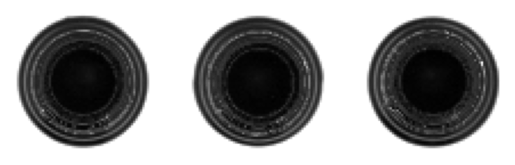

In [2]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(X_train[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

## 2. Model definition

An autoencoder is a neural network architecture designed to efficiently compress input data into a reduced latent space and then reconstruct the original input from that compressed representation. The model consists of two main components:

- **Encoder**: A sequence of layers that progressively reduce the dimensionality of the input, encoding it into a compact latent representation.
- **Decoder**: A sequence of layers that reconstruct the original input from the latent space generated by the encoder.

Autoencoders have various applications, including dimensionality reduction for downstream machine learning tasks, image denoising, colorizing grayscale images, and, most relevant to this project, anomaly detection. 

The dimensionality reduction causes that the model is only able to learn to reconstruct the most relevant information about the object. As a consequence, the more aggresive is the bottleneck the less likely is the model to reproduce the anomalies in the code-decode picture. Therefore, in order to identify the defective objects, it is only needed to apply the model and compare the reconstructed and real picture to see where both are more different.

The model implemented in this project is a simple **multi-layer perceptron (MLP)** autoencoder, constructed using fully connected layers without convolutional or recurrent operations. The activation functions for the hidden-layers are ReLU functions and the output layer is made off sigmoid neurons. The architecture is the following:
$$
\text{Image (dim } 4096 \text{)} \rightarrow 128 \rightarrow 64 \rightarrow 128 \rightarrow \text{ Reconstructed Image (dim }4096\text{)}
$$

In [3]:
class ReLU_neuron:
    @staticmethod
    def function(x):
        return np.maximum(0, x)
    @staticmethod
    def der(x):
        return (x > 0).astype(float)    

def stable_sigmoid(z):
    return np.where( z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

class Autoencoder:
    def __init__(self, input_dim, hidden_dim_encoder, hidden_dim_decoder, H, W, alpha = 0.9):
        self.weights_encoder = []
        self.biases_encoder = []
        self.weights_decoder = []
        self.biases_decoder = []
        self.H = H
        self.W = W
        self.alpha = alpha
        prev_d = input_dim
        for dim in hidden_dim_encoder:
            w = np.random.randn(prev_d, dim) * 0.01
            b = np.zeros((1, dim))
            self.weights_encoder.append(w)
            self.biases_encoder.append(b)
            prev_d = dim
            
        for dim in hidden_dim_decoder:
            w = np.random.randn(prev_d, dim) * 0.01
            b = np.zeros((1, dim))
            self.weights_decoder.append(w)
            self.biases_decoder.append(b)
            prev_d = dim
            
    def encoder(self, image):
        N = image.shape[0]
        z = image.reshape(N, -1)  
        for i in range(len(self.weights_encoder)):
            z = np.dot(z, self.weights_encoder[i]) + self.biases_encoder[i]
            z = ReLU_neuron.function(z)
        return z
    
    def decoder(self, z):
        for i in range(len(self.weights_decoder)):
            z = np.dot(z, self.weights_decoder[i]) + self.biases_decoder[i]
            if i < len(self.weights_decoder) - 1:
                z = ReLU_neuron.function(z)
            else:
                z = stable_sigmoid(z)
        N = z.shape[0]
        image = z.reshape(N, self.H, self.W, 1)
        return image
    
    def loss_function(self, X, X_hat):
        l1 = np.mean(np.abs(X - X_hat))
        l2 = np.mean((X - X_hat) ** 2)
        return self.alpha * l1 + (1 - self.alpha) * l2

Once the autoencoder is defined, I test whether it is able to reconstruct an image.

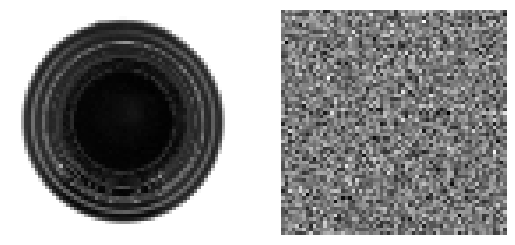

In [4]:
H, W = 64, 64
input_dim = H * W
ae = Autoencoder(input_dim, hidden_dim_encoder=[128, 64], hidden_dim_decoder=[128, input_dim], H=H, W=W)

code = ae.encoder(X_train)
reconstructed_1 = ae.decoder(code)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train[0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstructed_1[0], cmap='gray')
ax[1].axis('off')
plt.show()

## 3. Training

To train the autoencoder, we use the Adam optimizer, an adaptive learning rate method that combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. Adam maintains two moving averages for each parameter: the mean (first moment) and the uncentered variance (second moment) of the gradients. These allow it to scale the learning rate individually for each parameter, which improves convergence.

The parameters update are given by the following algorithm:

$$
m^{(t)}_w = \beta_1 m_w^{(t-1)} + (1-\beta_1) \nabla_w \mathcal{L}^{(t)}
$$

$$
v^{(t)}_w = \beta_2 v^{(t-1)}_w  + (1- \beta_2) \left(\nabla_w \mathcal{L}^{(t)}\right)^2
$$

$$
w^{(t)} = w^{(t-1)} - \eta\,\frac{m^{(t)}_w/(1-\beta_1^t)   }{\sqrt{v^{(t)}_m /(1-\beta_2^t)   } + \varepsilon }
$$

During training, the model receives batches of images and minimizes a reconstruction loss between the input and the output (reconstructed image). In this project, we use a combination of $L1$ and $L2$ losses. This makes the model sensitive to the initial big differences (L2 function) without getting trapped in blurry reconstruction as a consequence of smaller deviations (L1 function):
$$
\mathcal{L} =\sum_{\text{pixels}}  \alpha |\hat{x}_i - x_i| + (1-\alpha)(\hat{x}_i - x_i)^2
$$

### Backpropagation

To update the weights of the neural network, I used backpropagation, an algorithm used to compute the gradient of the loss by applying the chain rule layer by layer from the output back to the input. Specifically:
- In the output layer, I computed the derivative of the loss with respect to the final activation.

$$
\frac{\partial \mathcal{L}}{\partial  \hat{x}_i }  =\alpha \cdot sign(\hat{x}_i - x_i) + 2\cdot(1-\alpha)(\hat{x}_i - x_i) 
$$

    Assuming the output activation is a sigmoid, and denoting $z_i^{(end)}$ as the input to the output neuron (before activation), we have:
    
$$
\frac{\partial \hat{x}_i}{\partial z^{{end}}_i} =\hat{x}_i\cdot (1-\hat{x}_i)
$$

    Therefore, the full derivative becomes:
    
 $$
\frac{\partial \mathcal{L}}{\partial z^{\text{end}}_i} = 
\left[ \alpha \cdot \text{sign}(\hat{x}_i - x_i) + 2(1 - \alpha)(\hat{x}_i - x_i) \right] \cdot \hat{x}_i(1 - \hat{x}_i)
$$
    
- In the hidden layers, we propagate the error backward. Let $\delta_i^{(l)} := \frac{\partial \mathcal{L}}{\partial  z^{(l)}_i } $ be the error term at neuron $i$ in layer $l$. Then:

$$
\delta^{(l)} = \left(\delta^{(l+1)} \cdot W^{(l+1) T}\right) \odot \phi'(z^{(l)})
$$

    where $\odot$ is the element-wise product, $W^{(l+1) T}$ is the weight matrix of the next layer, and $\phi'(z^{(l)})$ is the derivative of the activation function.
- The gradient with respect to the weights is given by:

$$
\frac{\partial \mathcal{L}}{\partial w_{ij}^{(l)}} = \delta^{(l)}_i\cdot a_j^{(l-1)}
$$

    where $a_j^{(l-1)}$ is the activation of neuron $j$ from the previous layer.
    
By iteratively repeating this process for multiple epochs, the autoencoder learns to compress and reconstruct the input images with minimal loss.

In [5]:
def Grad_comp(ae, x):
        ### FORWARD STEP
        a = x.reshape(1, -1)
        activations = [a]
        zs = []
        
        for w, b in zip(ae.weights_encoder, ae.biases_encoder):
            z = np.dot(a, w) + b
            zs.append(z)
            a = ReLU_neuron.function(z)
            activations.append(a)
            
        for i, (w, b) in enumerate(zip(ae.weights_decoder, ae.biases_decoder)):
            z = np.dot(a, w) + b
            zs.append(z)
            if i < len(ae.weights_decoder) - 1:
                a = ReLU_neuron.function(z)
            else:
                a = stable_sigmoid(z)
            activations.append(a)

        x_hat = activations[-1]

        ### BACKPROP
        grads_w = [None] * (len(ae.weights_encoder) + len(ae.weights_decoder))
        grads_b = [None] * (len(ae.biases_encoder) + len(ae.biases_decoder))

        # Output Layer
        l1_grad = np.sign(x_hat - x.reshape(1, -1))
        l2_grad = 2 * (x_hat - x.reshape(1, -1))
        delta = ((ae.alpha * l1_grad + (1 - ae.alpha) * l2_grad) * (x_hat * (1 - x_hat)))/x.reshape(1, -1).shape[1]
        idx = len(grads_w) - 1
        grads_w[idx] = np.dot(activations[-2].T, delta)
        grads_b[idx] = delta

        # Hidden layers
        for l in reversed(range(len(grads_w) - 1)):
            w_next = ae.weights_decoder[l + 1 - len(ae.weights_encoder)] if l + 1 >= len(ae.weights_encoder) else ae.weights_encoder[l+1]
            delta = np.dot(delta, w_next.T) * ReLU_neuron.der(zs[l])
            grads_w[l] = np.dot(activations[l].T, delta)
            grads_b[l] = delta
        
        return grads_w, grads_b

    
def ADAM_optimization(images_train, images_val,ae, Batch_Size=32,Total_Epoch=40,lr=1e-3,beta_m=0.9,beta_v=0.999, eps=1e-8):
    # History of losses
    Loss_Train = np.zeros(Total_Epoch)
    Loss_Val   = np.zeros(Total_Epoch)

    # Flatten all parameters into a single list
    params = (  ae.weights_encoder  + ae.weights_decoder   + ae.biases_encoder   + ae.biases_decoder)

    # Initialize first and second moment vectors
    m = [np.zeros_like(p) for p in params]
    v = [np.zeros_like(p) for p in params]

    N_train = len(images_train)
    t = 0

    for epoch in range(Total_Epoch):
        # Shuffle training data
        perm = np.random.permutation(N_train)
        X = images_train[perm]

        # Mini-batch loop
        for batch_start in range(0, N_train, Batch_Size):
            t += 1
            batch = X[batch_start : batch_start + Batch_Size]

            # Accumulate gradients over the batch
            grad_list = [np.zeros_like(p) for p in params]
            for img in batch:
                grad_w, grad_b = Grad_comp(ae, img)
                grads = grad_w + grad_b
                for i in range(len(params)):
                    grad_list[i] += grads[i]

            # Average gradients
            for i in range(len(params)):
                grad_list[i] /= batch.shape[0]

            # Adam moment updates and bias correction
            for i, g in enumerate(grad_list):
                m[i] = beta_m * m[i] + (1 - beta_m) * g
                v[i] = beta_v * v[i] + (1 - beta_v) * (g ** 2)

                m_hat = m[i] / (1 - beta_m**t)
                v_hat = v[i] / (1 - beta_v**t)

                # Parameter update
                params[i] -= lr * m_hat / (np.sqrt(v_hat) + eps)

        # Compute losses at epoch end
        Loss_Train[epoch] = ae.loss_function(images_train, ae.decoder(ae.encoder(images_train)))
        Loss_Val[epoch]   = ae.loss_function(images_val, ae.decoder(ae.encoder(images_val)))
        
        # print( f"Epoch {epoch+1}/{Total_Epoch} | "f"Train Loss: {Loss_Train[epoch]:.4f} | "f"Val Loss:   {Loss_Val[epoch]:.4f}")

    return Loss_Train, Loss_Val

Once implemented, we can use the previous code-block to train the model. This is only done with non-defective images. The 80% of the training data is used directly in the training while the other 20% is used in validation.

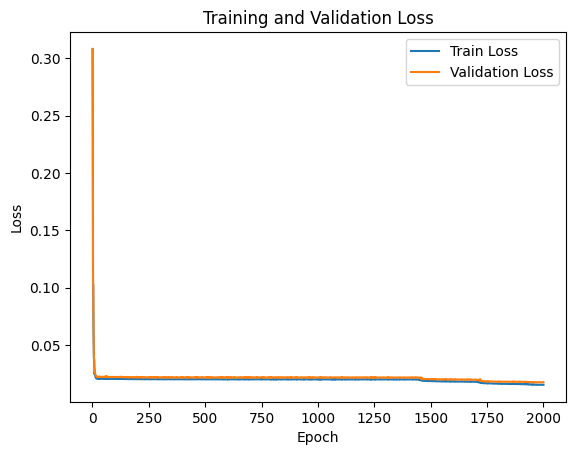

In [6]:
%%prun -l 20 -s cumulative

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X_train, test_size = 0.2, train_size = 0.8, random_state = 42)

loss_train, loss_val = ADAM_optimization(X_train, X_val, ae, Batch_Size=44, Total_Epoch=2000)

epochs = range(1, len(loss_train) + 1)

plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

The optimization is stoped after 2000 epoch to avoid overfitting to the training data.

Finally, with the trained model, we can try to reconstruct one of the validations picture.

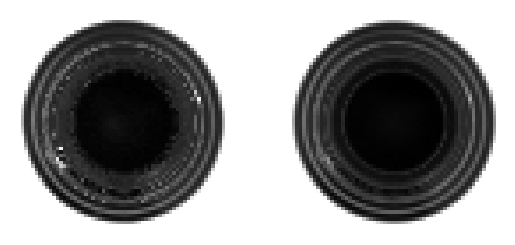

In [7]:
code = ae.encoder(X_val)
reconstructed = ae.decoder(code)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_val[7], cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstructed[7], cmap='gray')
ax[1].axis('off')
plt.show()

As shown in the previous image, the model can correctly reproduce the basic features of the real object. However, the pixel intensity and contrast is not correctly reproduced. This might cause that the model is not able to correctly identify subtile anomalies such as scratches or color errors.

## 4. Anomaly detection

Since the model has only been trained on non-defective objects, it has not learned to accurately reconstruct imperfections present in anomalous images. Therefore, we can feed the model with real-object images and compare the reconstructed output with the original input. Images with a reconstruction error above a certain threshold will be labeled as defective.

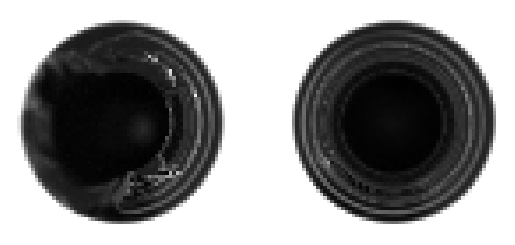

In [22]:
path_defect = '../data/bottle/test/broken_large/'
Image_defect = load_images(path_defect, image_size=(64, 64))

path_good = '../data/bottle/test/good/'
Image_good = load_images(path_good, image_size=(64, 64))

reconstructed_defect = ae.decoder(ae.encoder(Image_defect))
reconstructed_good = ae.decoder(ae.encoder(Image_good))

indx = 3
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Image_defect[indx], cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstructed_defect[indx], cmap='gray')
ax[1].axis('off')
plt.show()

The previous plot shows a practical example of how the autoencoder architecture can be used to obtain the damaged areas.

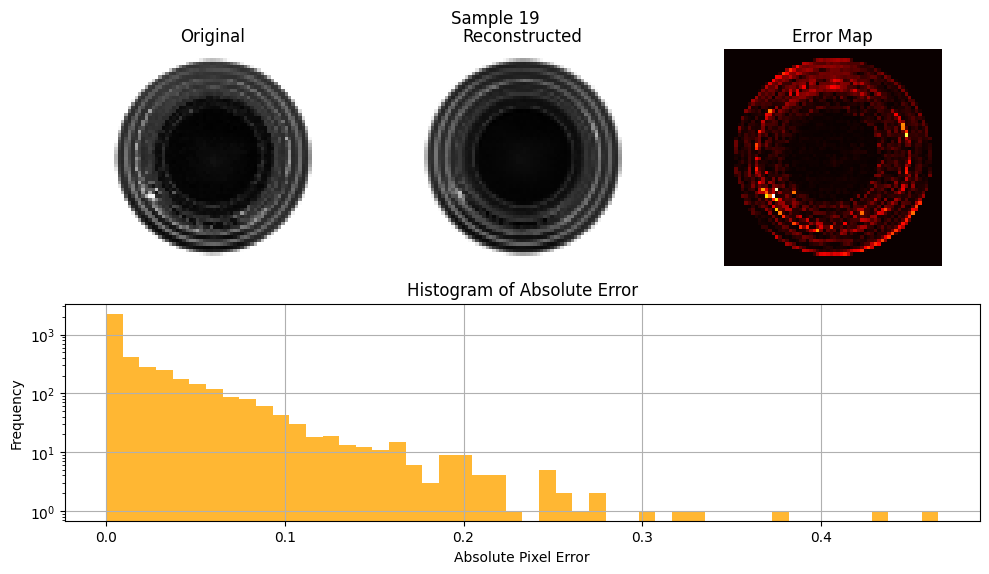

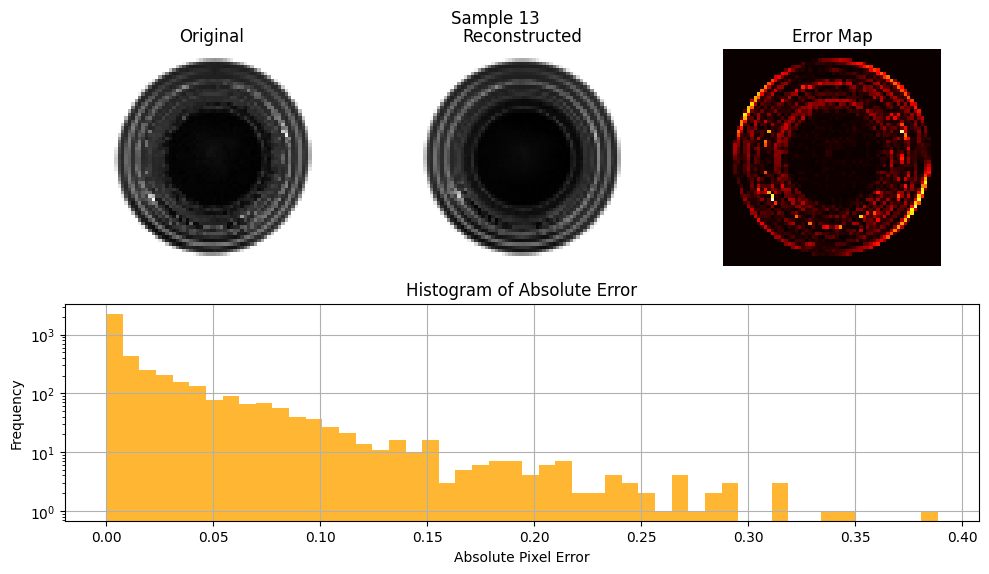

In [9]:
n = 2  # número de ejemplos a mostrar
indices = np.random.choice(len(Image_good), n, replace=False)

for i, idx in enumerate(indices):
    original = Image_good[idx].squeeze()
    reconstructed = reconstructed_good[idx].squeeze()
    difference = np.abs(original - reconstructed)

    fig = plt.figure(figsize=(10, 6))
    
    # Original
    plt.subplot(2, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruida
    plt.subplot(2, 3, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    # Diferencia (error map)
    plt.subplot(2, 3, 3)
    plt.imshow(difference, cmap='hot')
    plt.title("Error Map")
    plt.axis('off')

    # Histograma del error absoluto
    plt.subplot(2, 1, 2)
    plt.hist(difference.ravel(), bins=50, color='orange', alpha=0.8)
    plt.title("Histogram of Absolute Error")
    plt.xlabel("Absolute Pixel Error")
    plt.ylabel("Frequency")
    plt.yscale("log")
    plt.grid(True)

    plt.suptitle(f"Sample {idx}", y=0.95)
    plt.tight_layout()
    plt.show()

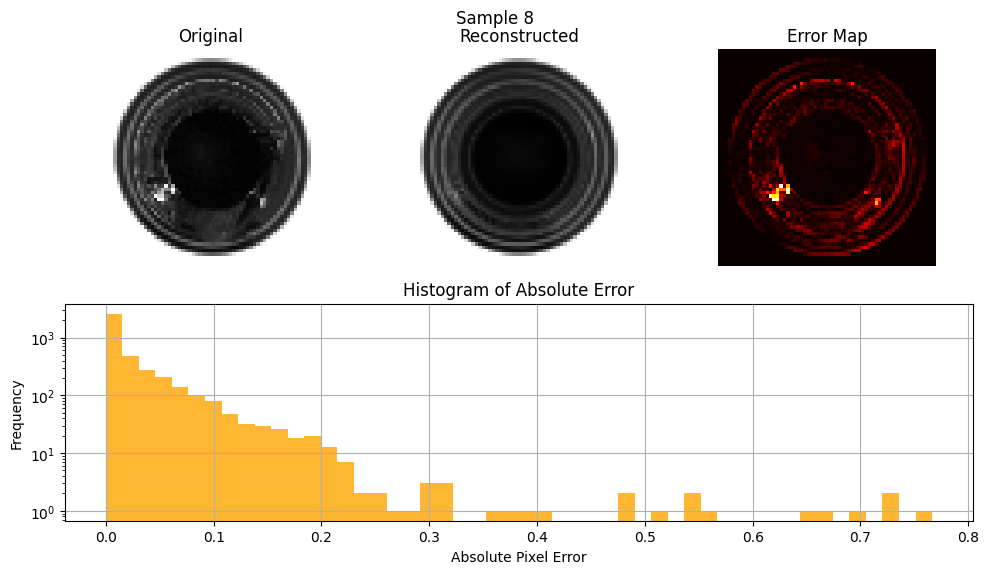

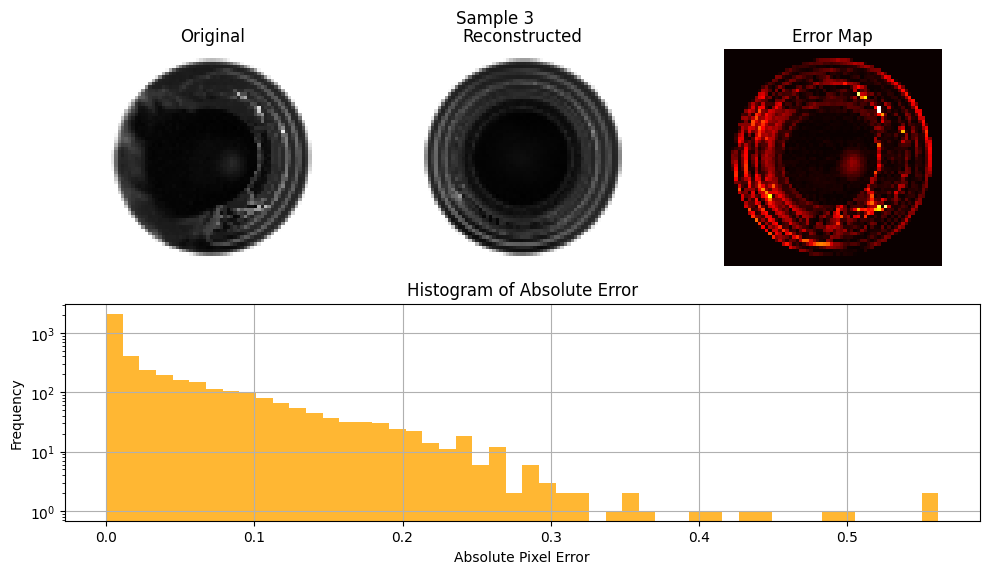

In [24]:
n = 2  # número de ejemplos a mostrar
indices = np.random.choice(len(Image_defect), n, replace=False)

for i, idx in enumerate(indices):
    original = Image_defect[idx].squeeze()
    reconstructed = reconstructed_defect[idx].squeeze()
    difference = np.abs(original - reconstructed)

    fig = plt.figure(figsize=(10, 6))
    
    # Original
    plt.subplot(2, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruida
    plt.subplot(2, 3, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    # Diferencia (error map)
    plt.subplot(2, 3, 3)
    plt.imshow(difference, cmap='hot')
    plt.title("Error Map")
    plt.axis('off')

    # Histograma del error absoluto
    plt.subplot(2, 1, 2)
    plt.hist(difference.ravel(), bins=50, color='orange', alpha=0.8)
    plt.title("Histogram of Absolute Error")
    plt.xlabel("Absolute Pixel Error")
    plt.ylabel("Frequency")
    plt.yscale("log")
    plt.grid(True)

    plt.suptitle(f"Sample {idx}", y=0.95)
    plt.tight_layout()
    plt.show()

In [25]:
error_defect = np.mean((Image_defect - reconstructed_defect) ** 2, axis=(1, 2, 3))
error_good = np.mean((Image_good - reconstructed_good) ** 2, axis=(1, 2, 3))
threshold = np.percentile(error_good, 95)

# Labels: 1 = defect, 0 = good
true_labels = np.concatenate([np.ones(len(error_defect)), np.zeros(len(error_good))])
predicted_labels = np.concatenate([
    (error_defect > threshold).astype(int),
    (error_good > threshold).astype(int)
])

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

Precision: 94.74%
Recall: 90.00%
F1 Score: 92.31%


Although these numbers seem impressive, this is a very simple case as a consequence of the object characteristics an damage size. More subtile anomalies require more advanced methods such as convolutional layers or other autoencoder models.

## 5. Following Steps

To further improve the model and extend its applications, the following steps are proposed:

- Use convolutional layers: Replace the MLP architecture with a convolutional autoencoder to better capture spatial features and fine-grained details in the images.
- Tune the anomaly threshold: Analyze the distribution of reconstruction errors on validation data to select an optimal threshold for classifying anomalies.
- Automate training and model creation:
 - Build reusable scripts or modular functions to accelerate the creation and configuration of new models with different architectures or hyperparameters.
 - Develop training pipelines that automate the training, validation, and logging processes, including checkpointing and early stopping if necessary
- Real-time deployment: Integrate the model into a real-time pipeline for on-the-fly defect detection in industrial settings.